# Load ClassEval dataset

In [1]:
from datasets import load_dataset
from pathlib import Path
from pprint import pprint
import json
import re
from copy import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = load_dataset("FudanSELab/ClassEval")
ds = dataset['test']
ds, ds[42]

(Dataset({
     features: ['task_id', 'skeleton', 'test', 'solution_code', 'import_statement', 'class_description', 'methods_info', 'class_name', 'test_classes', 'class_constructor', 'fields'],
     num_rows: 100
 }),
 {'task_id': 'ClassEval_42',
  'skeleton': 'class Hotel:\n    """\n    This is a class as hotel management system, managing the booking, check-in, check-out, and availability of rooms in a hotel with different room types.\n    """\n\n    def __init__(self, name, rooms):\n        """\n        Initialize the three fields in Hotel System.\n        name is the hotel name.\n        available_rooms stores the remaining rooms in the hotel\n        booked_rooms stores the rooms that have been booked and the person\'s name who booked rooms.\n        >>> hotel.name\n        \'peace hotel\'\n        >>> hotel.available_rooms\n        available_rooms = {\'single\': 5, \'double\': 3}\n        >>> hotel.booked_rooms\n        {\'single\': {\'guest 1\': 2, \'guest 2\':1}, \'double\': {\'

In [3]:
ds['methods_info'][0]

[{'method_name': 'filter',
  'method_description': 'def filter(self, request):\n        """\n        Filter the incoming request based on certain rules and conditions.\n        :param request: dict, the incoming request details\n        :return: bool, True if the request is allowed, False otherwise\n        >>> filter = AccessGatewayFilter()\n        >>> filter.filter({\'path\': \'/login\', \'method\': \'POST\'})\n        True\n\n        """',
  'test_class': 'AccessGatewayFilterTestFilter',
  'test_code': "class AccessGatewayFilterTestFilter(unittest.TestCase):\n    def test_filter_1(self):\n        agf = AccessGatewayFilter()\n        request = {'path': '/api/data', 'method': 'GET'}\n        res = agf.filter(request)\n        self.assertTrue(res)\n\n    def test_filter_2(self):\n        agf = AccessGatewayFilter()\n        request = {'path': '/api/data', 'method': 'POST'}\n        res = agf.filter(request)\n        self.assertTrue(res)\n\n    def test_filter_3(self):\n        agf = A

In [4]:
"""structure in nested manner
skeleton (imports + class definition + class summary + [method definition + method summary])
class_description (class summary)
class_constructor (class definition + constructor function definition + summary + code + fields)
solution_code (class code)
    import_statement
    class_name
    fields
    methods_info (array of objects)
        method_description (function definition + summary)
        solution_code
            method_name
            dependencies (function names used in code)
"""

'structure in nested manner\nskeleton (imports + class definition + class summary + [method definition + method summary])\nclass_description (class summary)\nclass_constructor (class definition + constructor function definition + summary + code + fields)\nsolution_code (class code)\n    import_statement\n    class_name\n    fields\n    methods_info (array of objects)\n        method_description (function definition + summary)\n        solution_code\n            method_name\n            dependencies (function names used in code)\n'

# Preprocessing

### 0. Add ids for each method

In [5]:
def add_method_ids(example):
    for i, method in enumerate(example['methods_info']):
        method['method_id'] = example['task_id'] + '_' + str(i)
    return example

ds = ds.map(add_method_ids)

### 1. Fix and extract summaries for methods (functional description)

In [6]:
def add_method_summary(example):
    for method in example['methods_info']:
        # Extract the method description and clean it up
        method_description = re.sub('”“”|“”“', '"""', method['method_description'])
        method_description = re.sub(r'^.*\"\"\"(.*?)(?::param|:return|>>>|\"\"\").*$', r'\1', method_description, flags=re.DOTALL).strip() 
        method_summary = re.sub('\s+', ' ', method_description)
        method['method_summary'] = method_summary
    return example

ds = ds.map(add_method_summary)

### 2. Fix and extract summaries for classes (functional description)

In [7]:
def add_class_summary(example):
    # Extract the class description and clean it up
    class_summary = re.sub('”“”|“”“|"""', '', example['class_description']).strip()
    class_summary = re.sub('\s+', ' ', class_summary)
    example['class_summary'] = class_summary
    return example

ds = ds.map(add_class_summary)

In [8]:
ds[0]

{'task_id': 'ClassEval_0',
 'skeleton': 'import logging\nimport datetime\n\nclass AccessGatewayFilter:\n    """\n    This class is a filter used for accessing gateway filtering, primarily for authentication and access log recording.\n    """\n\n    def __init__(self):\n        pass\n\n    def filter(self, request):\n        """\n        Filter the incoming request based on certain rules and conditions.\n        :param request: dict, the incoming request details\n        :return: bool, True if the request is allowed, False otherwise\n        >>> filter = AccessGatewayFilter()\n        >>> filter.filter({\'path\': \'/login\', \'method\': \'POST\'})\n        True\n\n        """\n\n\n    def is_start_with(self, request_uri):\n        """\n        Check if the request URI starts with certain prefixes.\n        :param request_uri: str, the URI of the request\n        :return: bool, True if the URI starts with certain prefixes, False otherwise\n        >>> filter = AccessGatewayFilter()\n    

### EDA

In [9]:
df = ds.to_pandas()
df.head(1)

,task_id,skeleton,test,solution_code,import_statement,class_description,methods_info,class_name,test_classes,class_constructor,fields,class_summary
0,ClassEval_0,import logging\nimport datetime\n\nclass Acces...,import unittest\n\nclass AccessGatewayFilterTe...,import logging\nimport datetime\n\n\nclass Acc...,"[import logging, import datetime]","""""""\n This class is a filter used for a...","[{'dependencies': {'Standalone': False, 'field...",AccessGatewayFilter,"[AccessGatewayFilterTestFilter, AccessGatewayF...",class AccessGatewayFilter: \n def __init__(...,[],This class is a filter used for accessing gate...


In [12]:
print(df.isnull().sum())

task_id              0
skeleton             0
test                 0
solution_code        0
import_statement     0
class_description    0
methods_info         0
class_name           0
test_classes         0
class_constructor    0
fields               0
class_summary        0
dtype: int64


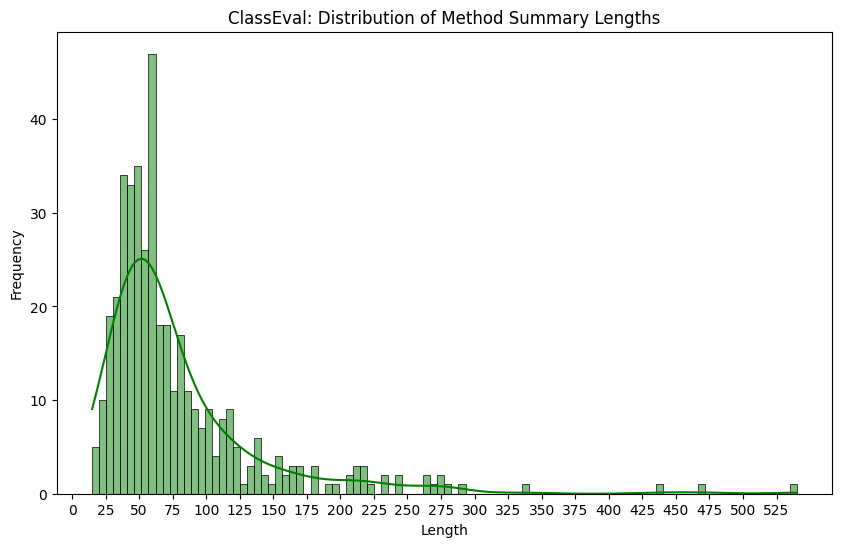

In [20]:
df_expanded = df.explode('methods_info').reset_index(drop=True)
df_expanded['method_summary_length'] = df_expanded['methods_info'].apply(lambda x: len(x['method_summary']) if x['method_summary'] else 0)

plt.figure(figsize=(10, 6))
sns.histplot(data=df_expanded, x='method_summary_length', bins=100, kde=True, color='green')
plt.title('ClassEval: Distribution of Method Summary Lengths')
plt.xlabel('Length')
plt.xticks(np.arange(0, 550, 25))
plt.ylabel('Frequency')
plt.show()

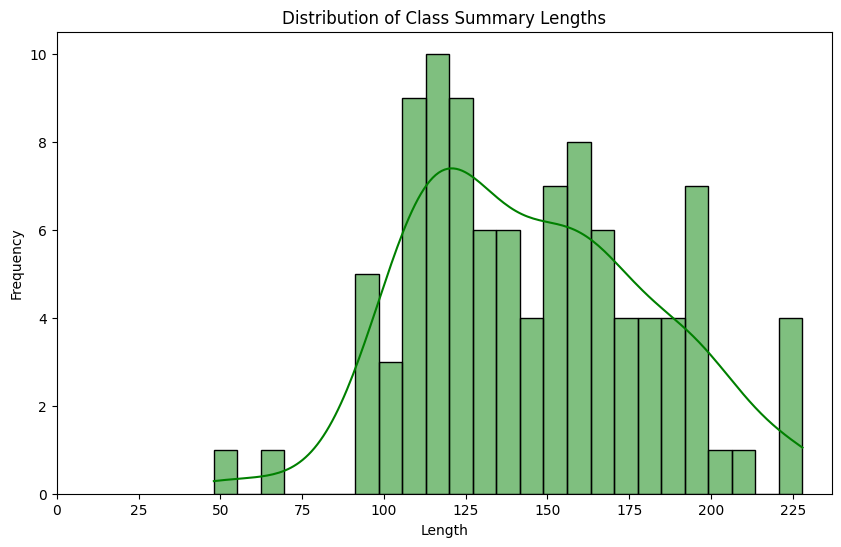

In [30]:
df['class_summary_length'] = df['class_summary'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='class_summary_length', bins=25, kde=True, color='green')
plt.title('Distribution of Class Summary Lengths')
plt.xlabel('Length')
plt.xticks(np.arange(0, 250, 25))
plt.ylabel('Frequency')
plt.show()

### Create a directory

In [10]:
DATA_DIR = Path('../../data/preprocessed/')
DATA_DIR.mkdir(parents=True, exist_ok=True)

## Method-level

### 0. Take 10 examples of method code + method summary for few-shot learning

In [10]:
data = []

for item in ds:
    for method in item['methods_info']:
        method_id = method['method_id']
        method_code = method['solution_code']
        method_summary = method['method_summary']

        data.append({'method_id': method_id, 'method_code': method_code, 'method_summary': method_summary})

df = pd.DataFrame(data)
df.head(1)

np.random.seed(7)
sampled_df = df.sample(n=10)
sampled_list = sampled_df.to_dict(orient='records')
pprint([i['method_summary'] for i in sampled_list])

['Stops the current song in the playlist.',
 'Get the status of specific order.',
 'Remove a user from the Chat.',
 'Deposits a certain amount into the account, increasing the account balance, '
 'return the current account balance. If amount is negative, raise a '
 'ValueError("Invalid amount").',
 'Inserts coins into the vending machine.',
 'According to product_id, add the quantity to the corresponding product in '
 'inventory.',
 'Extract all zip files and place them in the specified path',
 'Generate regular expression patterns that match the middle characters of two '
 'sentences',
 'Calculate the average value of a group of data, accurate to two digits after '
 'the Decimal separator',
 'Converts a two-digit number into words format']


In [11]:
file_path = DATA_DIR / "method-level-mce-few-shot.jsonl"
with open(file_path, 'w') as f:
    for item in sampled_list:
        json.dump(item, f)
        f.write('\n')

In [12]:
few_shot_ids = sampled_df['method_id'].values.tolist()
few_shot_ids

['ClassEval_61_3',
 'ClassEval_95_5',
 'ClassEval_20_1',
 'ClassEval_8_0',
 'ClassEval_94_1',
 'ClassEval_95_1',
 'ClassEval_99_1',
 'ClassEval_72_6',
 'ClassEval_29_0',
 'ClassEval_65_2']

In [13]:
sampled_list[3]

{'method_id': 'ClassEval_8_0',
 'method_code': 'def deposit(self, amount):\n        if amount < 0:\n            raise ValueError("Invalid amount")\n        self.balance += amount\n        return self.balance',
 'method_summary': 'Deposits a certain amount into the account, increasing the account balance, return the current account balance. If amount is negative, raise a ValueError("Invalid amount").'}

### 1. Method code + method summary

In [45]:
"""methods
[
    [{
        'method_code': raw str
        'method_summary': str (label)
    }]
]
"""

"methods\n[\n    [{\n        'method_code': raw str\n        'method_summary': str (label)\n    }]\n]\n"

In [46]:
# file_path = DATA_DIR / "method-level.jsonl"
# with open(file_path, 'w') as f:
#     for item in ds:
#         for method in item['methods_info']:
#             if method['method_id'] in few_shot_ids:
#                 continue
#             method_code = method['solution_code']
#             method_summary = method['method_summary']
#             f.write(json.dumps({'class_id': item['task_id'] + '_sum', 'method_code': method_code, 'method_summary': method_summary}) + "\n")

### 2. Method code with class code + method summary

In [14]:
"""
[
    [{
        'class_code': raw str without method_x
        'method_x_code' : raw str
        'method_x_summary': str (label)
    }]
]
"""

"\n[\n    [{\n        'class_code': raw str without method_x\n        'method_x_code' : raw str\n        'method_x_summary': str (label)\n    }]\n]\n"

In [13]:
file_path = DATA_DIR / "method-level-mce.jsonl"
with open(file_path, "w") as f:
    for item in ds:
        # Merge of class code and skeleton
        class_constructor = (
            item["class_constructor"][: item["class_constructor"].index(":") + 1] + "\n"
        )
        class_code = item["solution_code"].replace(
            class_constructor, class_constructor + item["class_description"]
        )
        skeleton = item["skeleton"]
        # Remove ith method making variations equal to number of method in class
        for i in range(len(item["methods_info"])):
            if item["methods_info"][i]["method_id"] in few_shot_ids:
                continue
            class_code_i = copy(class_code)
            skeleton_i = copy(skeleton)
            for j, method in enumerate(item["methods_info"]):
                if method["method_id"] in few_shot_ids:
                    class_code_i = class_code_i.replace(
                        "    " + method["solution_code"] + "\n\n", ""
                    )
                    skeleton_i = skeleton_i.replace(
                        method["method_description"] + "\n", ""
                    )
                    continue
                if i == j:
                    class_code_i = class_code_i.replace(
                        "    " + method["solution_code"] + "\n\n", ""
                    )
                    skeleton_i = skeleton_i.replace(
                        method["method_description"] + "\n", ""
                    )
                    method_code = method["solution_code"]
                    method_summary = method["method_summary"]
                    continue
                pattern = method["method_description"][
                    : method["method_description"].index(":") + 1
                ]
                class_code_i = class_code_i.replace(
                    pattern, method["method_description"] + "\n"
                )
            f.write(
                json.dumps(
                    {
                        "class_id": item["task_id"] + "_sum",
                        "class_code": class_code_i,
                        "skeleton": skeleton_i,
                        "method_code": method_code,
                        "method_summary": method_summary,
                    }
                )
                + "\n"
            )

with open(file_path) as f:
    for line in f:
        line = json.loads(line)
        print(line["class_code"])
        print(line["method_code"])
        print(line["method_summary"])
        break

import logging
import datetime


class AccessGatewayFilter:
    """
    This class is a filter used for accessing gateway filtering, primarily for authentication and access log recording.
    """

    def __init__(self):
        pass

    def is_start_with(self, request_uri):
        """
        Check if the request URI starts with certain prefixes.
        :param request_uri: str, the URI of the request
        :return: bool, True if the URI starts with certain prefixes, False otherwise
        >>> filter = AccessGatewayFilter()
        >>> filter.is_start_with('/api/data')
        True

        """

        start_with = ["/api", '/login']
        for s in start_with:
            if request_uri.startswith(s):
                return True
        return False

    def get_jwt_user(self, request):
        """
        Get the user information from the JWT token in the request.
        :param request: dict, the incoming request details
        :return: dict or None, the user information if

### 3. Method code with skeleton + method summary

In [51]:
"""
[
    [{
        'skeleton': raw str without method_x
        'method_x_code' : raw str
        'method_x_summary': str (label)
    }]
]
"""

"\n[\n    [{\n        'skeleton': raw str without method_x\n        'method_x_code' : raw str\n        'method_x_summary': str (label)\n    }]\n]\n"

In [19]:
# file_path = DATA_DIR / "method-level-with-skeleton.jsonl"
# with open(file_path, 'w') as f:
#     for item in ds:
#         skeleton = item['skeleton']
#         # Remove ith method making variations equal to number of method in class
#         for i in range(len(item['methods_info'])):
#             if item['methods_info'][i]['method_id'] in few_shot_ids:
#                 continue
#             skeleton_i = copy(skeleton)
#             for j, method in enumerate(item['methods_info']):
#                 if method['method_id'] in few_shot_ids:
#                     skeleton_i = skeleton_i.replace(method['method_description'] + '\n', '')
#                     continue
#                 if i == j:
#                     skeleton_i = skeleton_i.replace(method['method_description'] + '\n', '')
#                     method_code = method['solution_code']
#                     method_summary = method['method_summary']
#                     continue
#             f.write(json.dumps({'class_id': item['task_id'] + '_sum', 'skeleton': skeleton_i, 'method_code': method_code, 'method_summary': method_summary}) + "\n")

# with open(file_path) as f:
#     for line in f:
#         line = json.loads(line)
#         print(line['skeleton'])
#         print(line['method_code'])
#         print(line['method_summary'])
#         break

import logging
import datetime

class AccessGatewayFilter:
    """
    This class is a filter used for accessing gateway filtering, primarily for authentication and access log recording.
    """

    def __init__(self):
        pass

    

    def is_start_with(self, request_uri):
        """
        Check if the request URI starts with certain prefixes.
        :param request_uri: str, the URI of the request
        :return: bool, True if the URI starts with certain prefixes, False otherwise
        >>> filter = AccessGatewayFilter()
        >>> filter.is_start_with('/api/data')
        True

        """


    def get_jwt_user(self, request):
        """
        Get the user information from the JWT token in the request.
        :param request: dict, the incoming request details
        :return: dict or None, the user information if the token is valid, None otherwise
        >>> filter = AccessGatewayFilter()
        >>> filter.get_jwt_user({'headers': {'Authorization': {'user': {'nam

## Class-level

In [ ]:
"""classes
[
    {
        'class_code': raw str
        'class_summary': str (label) TODO: crop the summary string
    }
]
"""

In [ ]:
import json


file_path = DATA_DIR + "classic_class.jsonl"
with open(file_path, 'w') as f:
    for item in ds:
        class_code = item['solution_code']
        class_summary = item['class_description'].split('"""')[1].strip()
        element = {'task_id': item['task_id'] + '_sum', 'class_code': class_code, 'class_summary': class_summary }
        f.write(json.dumps(element) + "\n")

with open(file_path) as f:
    for line in f:
        print(line)
        break

{"task_id": "ClassEval_0_sum", "class_code": "import logging\nimport datetime\n\n\nclass AccessGatewayFilter:\n\n    def __init__(self):\n        pass\n\n    def filter(self, request):\n        request_uri = request['path']\n        method = request['method']\n\n        if self.is_start_with(request_uri):\n            return True\n\n        try:\n            token = self.get_jwt_user(request)\n            user = token['user']\n            if user['level'] > 2:\n                self.set_current_user_info_and_log(user)\n                return True\n        except:\n            return False\n\n    def is_start_with(self, request_uri):\n        start_with = [\"/api\", '/login']\n        for s in start_with:\n            if request_uri.startswith(s):\n                return True\n        return False\n\n    def get_jwt_user(self, request):\n        token = request['headers']['Authorization']\n        user = token['user']\n        if token['jwt'].startswith(user['name']):\n            jwt_st

In [ ]:
import json
import re

file_path = DATA_DIR + "classic_class_skeleton.jsonl"
with open(file_path, 'w') as f:
    for item in ds:
        skeleton = re.sub(item['class_description'], '', item['skeleton'])
        class_summary = item['class_description'].split('"""')[1].strip()
        element = {'task_id': item['task_id'] + '_sum', 'skeleton': skeleton, 'class_summary': class_summary }
        f.write(json.dumps(element) + "\n")

with open(file_path) as f:
    for line in f:
        print(line)
        break

{"task_id": "ClassEval_0_sum", "skeleton": "\nimport logging\nimport datetime\n\nclass AccessGatewayFilter:\n\n    def __init__(self):\n        pass\n\n    def filter(self, request):\n        \"\"\"\n        Filter the incoming request based on certain rules and conditions.\n        :param request: dict, the incoming request details\n        :return: bool, True if the request is allowed, False otherwise\n        >>> filter = AccessGatewayFilter()\n        >>> filter.filter({'path': '/login', 'method': 'POST'})\n        True\n\n        \"\"\"\n\n\n    def is_start_with(self, request_uri):\n        \"\"\"\n        Check if the request URI starts with certain prefixes.\n        :param request_uri: str, the URI of the request\n        :return: bool, True if the URI starts with certain prefixes, False otherwise\n        >>> filter = AccessGatewayFilter()\n        >>> filter.is_start_with('/api/data')\n        True\n\n        \"\"\"\n\n\n    def get_jwt_user(self, request):\n        \"\"\"\n